In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.7.0
Eager execution: True


In [2]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /home/maker/.keras/datasets/iris_training.csv


head -n5 {train_dataset_fp}

```
120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0

From this view of the dataset, notice the following:

The first line is a header containing information about the dataset:
There are 120 total examples. Each example has four features and one of three possible label names.
Subsequent rows are data records, one example per line, where:
The first four fields are features: these are the characteristics of an example. Here, the fields hold float numbers representing flower measurements.
The last column is the label: this is the value we want to predict. For this dataset, it's an integer value of 0, 1, or 2 that corresponds to a flower name.
```

In [3]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [4]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

In [5]:
# Create tf.data.Dataset

In [6]:
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names = column_names,
    label_name = label_name,
    num_epochs=1)


2021-09-14 13:50:19.177776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47220 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:67:00.0, compute capability: 7.5
2021-09-14 13:50:19.179278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46913 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:68:00.0, compute capability: 7.5


The make_csv_dataset function returns a tf.data.Dataset of (features, label) pairs, where features is a dictionary: {'feature_name': value}

These Dataset objects are iterable. Let's look at a batch of features:

In [7]:
features, labels = next(iter(train_dataset))

In [8]:
print(features)

OrderedDict([('sepal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([4.6, 6.9, 4.9, 5.1, 5.2, 7.2, 6.6, 5.4, 4.9, 6.8, 5.8, 6.3, 6.3,
       7.7, 4.8, 7.7, 5.5, 5.7, 6. , 7.7, 6.8, 6.1, 5. , 7.2, 5.9, 5.7,
       5.6, 5.5, 5. , 6.1, 6.8, 6.3], dtype=float32)>), ('sepal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([3.6, 3.1, 3.1, 3.7, 3.5, 3.2, 2.9, 3.9, 3. , 2.8, 2.7, 2.5, 2.7,
       2.8, 3. , 3.8, 2.4, 2.9, 2.7, 2.6, 3.2, 2.8, 3.6, 3. , 3. , 2.8,
       2.7, 3.5, 3.5, 2.6, 3. , 2.3], dtype=float32)>), ('petal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([1. , 4.9, 1.5, 1.5, 1.5, 6. , 4.6, 1.7, 1.4, 4.8, 5.1, 5. , 4.9,
       6.7, 1.4, 6.7, 3.7, 4.2, 5.1, 6.9, 5.9, 4.7, 1.4, 5.8, 5.1, 4.5,
       4.2, 1.3, 1.3, 5.6, 5.5, 4.4], dtype=float32)>), ('petal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0.2, 1.5, 0.1, 0.4, 0.2, 1.8, 1.3, 0.4, 0.2, 1.4, 1.9, 1.9, 1.8,
       2. , 0.3, 2.2, 1. , 1.3, 1.6, 2.3, 2.3, 1.2, 0.2, 1.6,

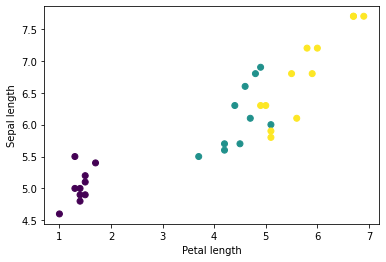

In [9]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

To simplify the model building step, create a function to repackage the features dictionary into a single array with shape: (batch_size, num_features).

This function uses the tf.stack method which takes values from a list of tensors and creates a combined tensor at the specified dimension:

In [10]:
def pack_features_vector(features, labels):
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

Then use the tf.data.Dataset#map method to pack the features of each (features,label) pair into the training dataset:

In [11]:
train_dataset = train_dataset.map(pack_features_vector)

In [12]:
features, labels = next(iter(train_dataset))


In [13]:
print (features)

tf.Tensor(
[[5.7 3.  4.2 1.2]
 [4.9 3.1 1.5 0.1]
 [6.2 2.2 4.5 1.5]
 [4.8 3.1 1.6 0.2]
 [4.6 3.6 1.  0.2]
 [7.2 3.2 6.  1.8]
 [6.  2.2 5.  1.5]
 [6.4 2.8 5.6 2.1]
 [5.2 3.4 1.4 0.2]
 [4.8 3.  1.4 0.3]
 [5.8 2.6 4.  1.2]
 [6.7 3.1 4.4 1.4]
 [6.3 2.7 4.9 1.8]
 [6.7 3.  5.  1.7]
 [6.1 2.8 4.  1.3]
 [5.9 3.2 4.8 1.8]
 [4.4 2.9 1.4 0.2]
 [5.7 2.8 4.5 1.3]
 [5.  3.4 1.5 0.2]
 [5.7 2.8 4.1 1.3]
 [6.8 2.8 4.8 1.4]
 [6.5 3.  5.5 1.8]
 [6.9 3.1 4.9 1.5]
 [5.  2.  3.5 1. ]
 [4.7 3.2 1.3 0.2]
 [5.1 3.8 1.5 0.3]
 [6.  2.9 4.5 1.5]
 [4.6 3.4 1.4 0.3]
 [6.7 3.  5.2 2.3]
 [5.7 2.9 4.2 1.3]
 [6.1 2.6 5.6 1.4]
 [5.  3.6 1.4 0.2]], shape=(32, 4), dtype=float32)


In [14]:
print (labels)

tf.Tensor([1 0 1 0 0 2 2 2 0 0 1 1 2 1 1 1 0 1 0 1 1 2 1 1 0 0 1 0 2 1 2 0], shape=(32,), dtype=int32)


In [15]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

In [16]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-0.04451322,  1.0850911 , -0.5574042 ],
       [ 0.12403236,  0.7431654 , -0.38246706],
       [ 0.12671532,  1.3472618 , -0.60754204],
       [ 0.12109759,  0.7357392 , -0.37964082],
       [ 0.23068957,  0.650328  , -0.32333103]], dtype=float32)>

In [17]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.2130745 , 0.65934455, 0.12758093],
       [0.28902414, 0.5368095 , 0.17416634],
       [0.20538515, 0.6960584 , 0.09855646],
       [0.2894292 , 0.53515273, 0.17541808],
       [0.32299262, 0.49140462, 0.18560278]], dtype=float32)>

In [18]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
    Labels: [1 0 1 0 0 2 2 2 0 0 1 1 2 1 1 1 0 1 0 1 1 2 1 1 0 0 1 0 2 1 2 0]


# Train the model

## Define the loss and gradient function

In [20]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [21]:
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)


l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Loss test: 1.0940660238265991


Use the tf.GradientTape context to calculate the gradients used to optimize your model:

In [22]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

## Create an optimizer

In [23]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [24]:
# single optimization step

loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))

Step: 0, Initial Loss: 1.0940660238265991
Step: 1,         Loss: 1.05594003200531


## Training loop

In [25]:
## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.203, Accuracy: 57.500%
Epoch 050: Loss: 0.772, Accuracy: 76.667%
Epoch 100: Loss: 0.394, Accuracy: 97.500%
Epoch 150: Loss: 0.246, Accuracy: 95.833%
Epoch 200: Loss: 0.164, Accuracy: 98.333%


In [26]:
## Visualize the loss function over time


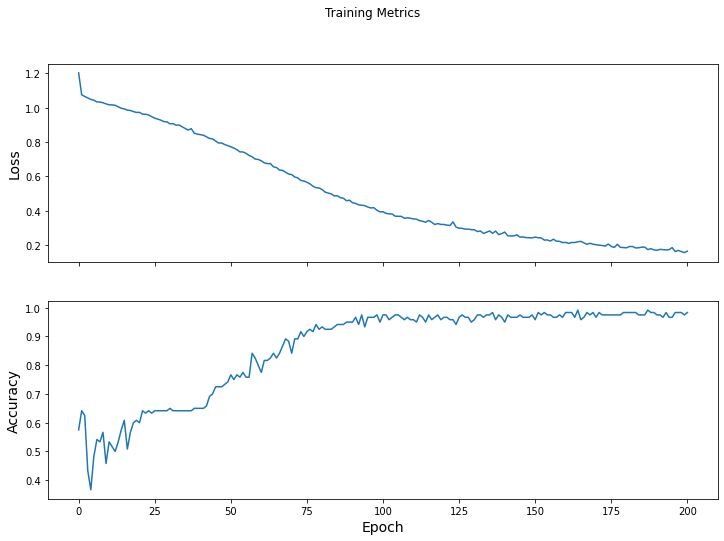

In [27]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

## Setup the test dataset

In [28]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

16384/573 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [29]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

# Evaluate the model on the test dataset

In [30]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  # training=False is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model(x, training=False)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


We can see on the last batch, for example, the model is usually correct:

In [32]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 2],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]], dtype=int32)>

In [33]:
## Use the trained model to make predictions

In [34]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

# training=False is needed only if there are layers with different
# behavior during training versus inference (e.g. Dropout).
predictions = model(predict_dataset, training=False)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (95.5%)
Example 1 prediction: Iris versicolor (85.0%)
Example 2 prediction: Iris virginica (69.5%)
